In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 20)
import matplotlib
matplotlib.get_backend()
%matplotlib inline
plt.style.use('seaborn')
import re
import scikitplot as skplt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from imblearn.over_sampling import ADASYN

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [3]:
def score_cross_val(scores):
    
    # Scores sur cross validation
    scores = pd.DataFrame(scores)
    scores.plot()

    plt.xlabel('CV')
    plt.ylabel('Score')
    plt.title("Scores sur le train de chaque cross validation")

    plt.axis()
    plt.legend("scores", loc='upper center')
    plt.show()

def plot_roc_auc_curve(model, X_test, y_test):
    
    # overall accuracy
    acc = model.score(X_test, y_test)

    # get roc/auc info
    # predict_proba is the porbability that X takes a class
    Y_score = model.predict_proba(X_test)[:, 1] 
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, Y_score)

    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
    plt.legend(loc="lower right", shadow=True, fancybox=True)
    plt.title('ROC curve and AUC')
    plt.show()


def plot_corr_matrix(df):
    
    data_correlation = df[list(df.columns)].corr()
    mask = np.array(data_correlation)
    mask[np.tril_indices_from(mask)] = False
    fig = plt.subplots(figsize=(30,20))
    sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True);

In [4]:
df = pd.read_excel('Date_Fruit_Datasets.xlsx')
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,...,898.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02,8.980000e+02,898.000000,898.000000,898.000000
mean,298295.207127,2057.660953,750.811994,495.872785,0.737468,604.577938,0.981840,303845.592428,0.736267,2.131102,...,0.250518,4.247845,5.110894,3.780928,-3.185021e+10,-2.901860e+10,-2.771876e+10,50.082888,48.805681,48.098393
std,107245.205337,410.012459,144.059326,114.268917,0.088727,119.593888,0.018157,108815.656947,0.053745,17.820778,...,0.632918,2.892357,3.745463,2.049831,2.037241e+10,1.712952e+10,1.484137e+10,16.063125,14.125911,10.813862
min,1987.000000,911.828000,336.722700,2.283200,0.344800,50.298400,0.836600,2257.000000,0.512300,1.065300,...,-1.029100,1.708200,1.607600,1.767200,-1.091224e+11,-9.261697e+10,-8.747177e+10,15.191100,20.524700,22.130000
25%,206948.000000,1726.091500,641.068650,404.684375,0.685625,513.317075,0.978825,210022.750000,0.705875,1.373725,...,-0.196950,2.536625,2.508850,2.577275,-4.429444e+10,-3.894638e+10,-3.564534e+10,38.224425,38.654525,39.250725
50%,319833.000000,2196.345450,791.363400,495.054850,0.754700,638.140950,0.987300,327207.000000,0.746950,1.524150,...,0.135550,3.069800,3.127800,3.080700,-2.826156e+10,-2.620990e+10,-2.392928e+10,53.841300,50.337800,49.614100
75%,382573.000000,2389.716575,858.633750,589.031700,0.802150,697.930525,0.991800,388804.000000,0.775850,1.674750,...,0.593950,4.449850,7.320400,4.283125,-1.460482e+10,-1.433105e+10,-1.660367e+10,63.063350,59.573600,56.666675
max,546063.000000,2811.997100,1222.723000,766.453600,1.000000,833.827900,0.997400,552598.000000,0.856200,535.525700,...,3.092300,26.171100,26.736700,32.249500,-1.627316e+08,-5.627727e+08,-4.370435e+08,79.828900,83.064900,74.104600


In [6]:
df.columns

Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2',
       'SHAPEFACTOR_3', 'SHAPEFACTOR_4', 'MeanRR', 'MeanRG', 'MeanRB',
       'StdDevRR', 'StdDevRG', 'StdDevRB', 'SkewRR', 'SkewRG', 'SkewRB',
       'KurtosisRR', 'KurtosisRG', 'KurtosisRB', 'EntropyRR', 'EntropyRG',
       'EntropyRB', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB', 'Class'],
      dtype='object')

In [7]:
df.dtypes

AREA               int64
PERIMETER        float64
MAJOR_AXIS       float64
MINOR_AXIS       float64
ECCENTRICITY     float64
EQDIASQ          float64
SOLIDITY         float64
CONVEX_AREA        int64
EXTENT           float64
ASPECT_RATIO     float64
ROUNDNESS        float64
COMPACTNESS      float64
SHAPEFACTOR_1    float64
SHAPEFACTOR_2    float64
SHAPEFACTOR_3    float64
SHAPEFACTOR_4    float64
MeanRR           float64
MeanRG           float64
MeanRB           float64
StdDevRR         float64
StdDevRG         float64
StdDevRB         float64
SkewRR           float64
SkewRG           float64
SkewRB           float64
KurtosisRR       float64
KurtosisRG       float64
KurtosisRB       float64
EntropyRR          int64
EntropyRG          int64
EntropyRB          int64
ALLdaub4RR       float64
ALLdaub4RG       float64
ALLdaub4RB       float64
Class             object
dtype: object

In [8]:
df.Class.value_counts(normalize=True)

DOKOL     0.227171
SAFAVI    0.221604
ROTANA    0.184855
DEGLET    0.109131
SOGAY     0.104677
IRAQI     0.080178
BERHI     0.072383
Name: Class, dtype: float64

In [9]:
set(df.Class)

{'BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY'}

In [10]:
df.shape

(898, 35)

In [11]:
ord_enc = OrdinalEncoder()
df["Class"] = ord_enc.fit_transform(df[["Class"]])

/Users/robinmasliah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


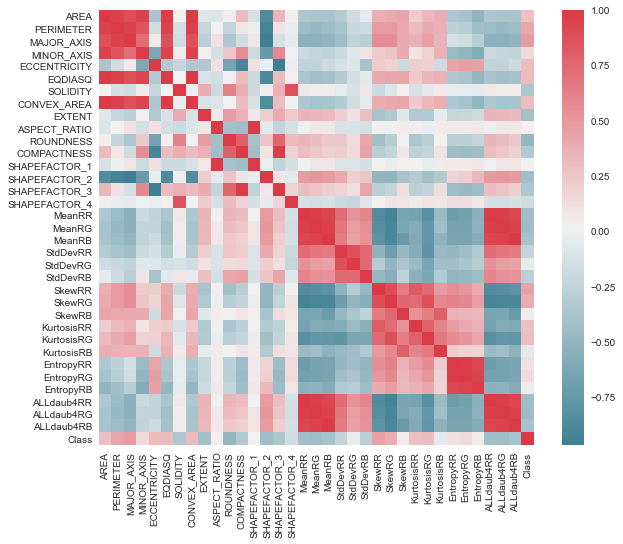

In [12]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

In [13]:
X = df.loc[:, df.columns != 'Class']
y = df['Class']

In [14]:
# Over-sampling
ada = ADASYN(sampling_strategy='minority')
X_resampled, y_resampled = ada.fit_sample(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
gradb = GradientBoostingClassifier(n_estimators=150)
gradb.fit(X_train, y_train)
scores = cross_val_score(gradb, X_train, y_train, cv=10)
y_pred_gradb = gradb.predict(X_test)
y_pred_gradb_probas = gradb.predict_proba(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_gradb))
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_gradb)
print(cf_matrix)

Accuracy: 0.882
[[31  0  0  0  2  0  0]
 [ 0 12  2  0  3  0  1]
 [ 0  2 41  0  0  0  1]
 [ 3  0  0  8  2  1  0]
 [ 0  0  0  0 34  0  2]
 [ 0  0  0  0  0 44  0]
 [ 1  3  0  0  2  0 17]]


In [17]:
forest = RandomForestClassifier(n_estimators=150, max_depth=6, class_weight="balanced")

forest.fit(X_train, y_train)
scores = cross_val_score(forest, X_train, y_train, cv=10)
y_pred_forest = forest.predict(X_test)
y_pred_forest_probas = forest.predict_proba(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_forest))
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_forest)
print(cf_matrix)

Accuracy: 0.882
[[29  0  0  3  0  0  1]
 [ 0 11  2  0  2  0  3]
 [ 0  2 42  0  0  0  0]
 [ 2  0  0 11  1  0  0]
 [ 1  0  0  0 33  0  2]
 [ 0  0  0  0  0 43  1]
 [ 0  5  0  0  0  0 18]]


In [18]:
xgb = XGBClassifier(max_depth=6,
                    learning_rate=0.1,
                    n_estimators=150)

xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=10)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_probas = xgb.predict_proba(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_xgb))
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(cf_matrix)

Accuracy: 0.892
[[31  0  0  0  2  0  0]
 [ 0 13  2  0  2  0  1]
 [ 0  2 42  0  0  0  0]
 [ 3  0  0  8  2  1  0]
 [ 0  0  0  1 33  0  2]
 [ 0  0  0  0  0 44  0]
 [ 0  3  0  0  2  0 18]]


In [21]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93        33
         1.0       0.72      0.72      0.72        18
         2.0       0.95      0.95      0.95        44
         3.0       0.89      0.57      0.70        14
         4.0       0.80      0.92      0.86        36
         5.0       0.98      1.00      0.99        44
         6.0       0.86      0.78      0.82        23

    accuracy                           0.89       212
   macro avg       0.87      0.84      0.85       212
weighted avg       0.89      0.89      0.89       212



In [25]:
ensemble_list = [('gradient_boosting', gradb), 
                 ('random_forest', forest), 
                 ('xgboost', xgb)]

ensemble = VotingClassifier(ensemble_list)
ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)
print(accuracy_score(y_test, ensemble_preds))
print(classification_report(y_test, ensemble_preds))

0.8962264150943396
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93        33
         1.0       0.72      0.72      0.72        18
         2.0       0.95      0.95      0.95        44
         3.0       0.89      0.57      0.70        14
         4.0       0.81      0.94      0.87        36
         5.0       0.98      1.00      0.99        44
         6.0       0.90      0.78      0.84        23

    accuracy                           0.90       212
   macro avg       0.88      0.84      0.86       212
weighted avg       0.90      0.90      0.89       212



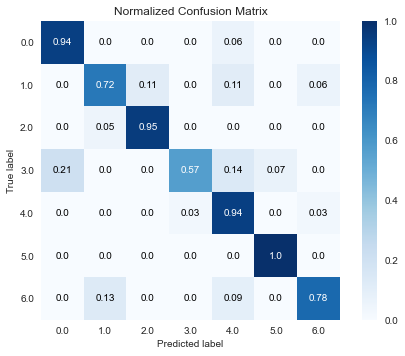

In [26]:
skplt.metrics.plot_confusion_matrix(y_test, ensemble_preds, normalize=True)
plt.show()

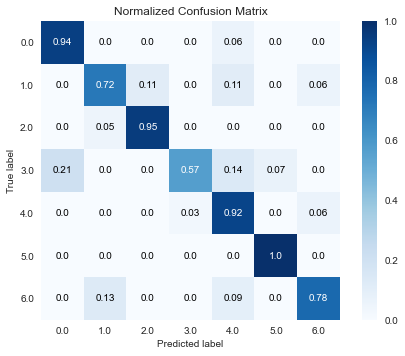

In [19]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgb, normalize=True)
plt.show()

/Users/robinmasliah/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


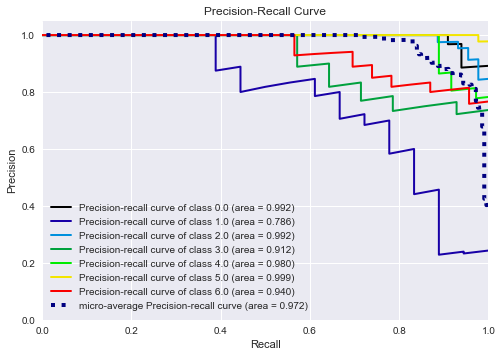

In [20]:
probas = xgb.predict_proba(X_test)
skplt.metrics.plot_precision_recall_curve(y_test, probas)
plt.show()